In [1]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [2]:
!pip install -U -q PyDrive

#File ID
zip_id = '1C8Fz--k6a9wmqLLif1FvEQcDOYLFqiYJ'

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile, os

In [3]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
# Download the zip file
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('Food-5K.zip')

In [5]:
!unzip -qq -o Food-5K.zip

!mv Food-5K/* .

In [6]:
# Make appropriate directories 
!mkdir data
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food

In [7]:
# Move the images
# Note: we will consider 'training' to be the train set
#       'validation' folder will be the test set
#       ignore the 'evaluation' set
!mv training/0*.jpg data/train/nonfood
!mv training/1*.jpg data/train/food
!mv validation/0*.jpg data/test/nonfood
!mv validation/1*.jpg data/test/food

train_path = 'data/train'
valid_path = 'data/test'

In [8]:
# These images are pretty big and of different sizes
# Let's load them all in as the same (smaller) size
IMAGE_SIZE = [200, 200]

# useful for getting number of files
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

# useful for getting number of classes
folders = glob(train_path + '/*')

In [9]:
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False)

58900480/58889256 [==============================] - 0s 0us/step


In [14]:
# map the data into feature vectors
# We don't need any dense layer, we are just extracting precomputed features  for approach1
x = Flatten()(ptm.output)

In [15]:
# create a model object
model = Model(inputs=ptm.input, outputs=x)

In [16]:
# view the structure of the model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0   

In [17]:
# create an instance of ImageDataGenerator (passing only prerpocessed input - but no augmentation information)
gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [18]:
batch_size = 128

# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
  class_mode='binary',
)

valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
  class_mode='binary',
)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [20]:
# Creating a tabular dataset for all the image features - Take an image run it trhough stage1 and add it to feature vector matrix ony by one
# Each row representas an image in a vector form
# Number of training and testing images
Ntrain = len(image_files) #Gives the number of training images
Nvalid = len(valid_image_files) #Gives the number of test images

In [22]:
# Passing on the random input to know the size required by model
# Figure out the output size
feat = model.predict(np.random.random([1] + IMAGE_SIZE + [3]))
D = feat.shape[1]  #Gives number of features per image (flattened dimensionality)

# Initialize with number of features per image
X_train = np.zeros((Ntrain, D)) #Ntrain nuumber of rows, D number of columns
Y_train = np.zeros(Ntrain)   #Ntrain number of rows for target values of each image
X_valid = np.zeros((Nvalid, D)) 
Y_valid = np.zeros(Nvalid)

In [23]:
# populate X_train and Y_train
i = 0  #which sample we are currently populating within the loop
for x, y in train_generator:   #Generate X and y tuples at each step (batch of images not one image) (128 in every batch except last one)
  # get features
  features = model.predict(x)  # predicting on each images of (128 total in batch)
  
  # size of the batch (may not always be batch_size)
  sz = len(y)                  
  
  # assign to X_train and Ytrain
  X_train[i:i + sz] = features        #Assign the features a 2dimensional array to X_train(128XD)
  Y_train[i:i + sz] = y               #Assign y to y_train (128)
  
  # increment i                      # incrementing by batch size (128)
  i += sz
  print(i)

  if i >= Ntrain:
    print('breaking now')
    break
print(i)

128
256
384
512
640
768
896
1024
1152
1280
1408
1536
1664
1792
1920
2048
2176
2304
2432
2560
2688
2816
2944
3000
breaking now
3000


In [24]:
# populate X_valid and Y_valid
i = 0
for x, y in valid_generator:
  # get features
  features = model.predict(x)
  
  # size of the batch (may not always be batch_size)
  sz = len(y)
  
  # assign to X_train and Ytrain
  X_valid[i:i + sz] = features
  Y_valid[i:i + sz] = y
  
  # increment i
  i += sz

  if i >= Nvalid:
    print('breaking now')
    break
print(i)

breaking now
1000


In [25]:
X_train.max(), X_train.min()

(650.8261108398438, 0.0)

In [26]:
# Whether to do normalization or not??? - Check the range of processed data (X_train,y_train)
# We will do it
#Normalization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train2 = scaler.fit_transform(X_train)
X_valid2 = scaler.transform(X_valid)

In [27]:
# Try the scikit-learn logistic regression

from sklearn.linear_model import LogisticRegression
logr = LogisticRegression()
logr.fit(X_train2, Y_train)
print(logr.score(X_train2, Y_train))
print(logr.score(X_valid2, Y_valid))

1.0
0.979


In [28]:
# Do logistic regression in Tensorflow

i = Input(shape=(D,))
x = Dense(1, activation='sigmoid')(i)
linearmodel = Model(i, x)

linearmodel.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

r = linearmodel.fit(
    X_train2, Y_train,
    batch_size=128,
    epochs=10,
    validation_data=(X_valid2, Y_valid),
)

Epoch 1/10
24/24 [==============================] - 2s 20ms/step - loss: 0.1570 - accuracy: 0.9400 - val_loss: 0.0557 - val_accuracy: 0.9820
Epoch 2/10
24/24 [==============================] - 0s 9ms/step - loss: 0.0126 - accuracy: 0.9970 - val_loss: 0.0573 - val_accuracy: 0.9820
Epoch 3/10
24/24 [==============================] - 0s 11ms/step - loss: 0.0034 - accuracy: 0.9997 - val_loss: 0.0554 - val_accuracy: 0.9830
Epoch 4/10
24/24 [==============================] - 0s 9ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0542 - val_accuracy: 0.9830
Epoch 5/10
24/24 [==============================] - 0s 11ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0534 - val_accuracy: 0.9830
Epoch 6/10
24/24 [==============================] - 0s 11ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0530 - val_accuracy: 0.9820
Epoch 7/10
24/24 [==============================] - 0s 10ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0529 - val_accuracy: 0.9820
Epoch 8/10
24/2

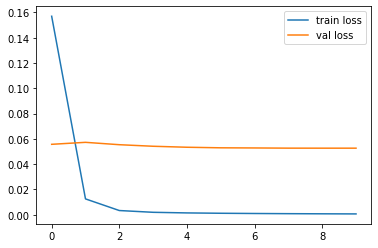

In [29]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

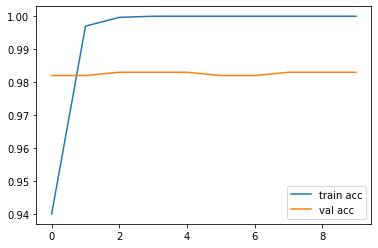

In [30]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()